In [1]:
import pandas as pd
from IPython.display import display
import numpy as np

import pathlib as pl
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

%matplotlib inline

In [2]:
def remove_numerics(s):
    return ''.join(i for i in s if not i.isdigit())
def filename_process(s):
    _s = remove_numerics(s)
    return _s.replace(".txt","").replace(".","")

In [3]:
list(pl.Path("../PCA/").glob("*"))

[PosixPath('../PCA/Concrete'),
 PosixPath('../PCA/AirFoil'),
 PosixPath('../PCA/Protein'),
 PosixPath('../PCA/ToyData'),
 PosixPath('../PCA/Parkinson')]

In [59]:
methods = ['2MeansSVM','Iso','PCA','LeastSquares']
datasets = ["Concrete", "AirFoil", "Protein"
            , "ToyData", "Parkinson"]


In [141]:
from data_reader import reader
from importlib import reload
reload(reader)

<module 'data_reader.reader' from '/Users/uriamor/Documents/TAU/Wavelet_Unis_2/results/jupyter_notebooks/data_reader/reader.py'>

In [146]:
from pandas.plotting import table
train = []
test = []
valid = []
for ds in datasets:
    res = reader.WFResultsReader(ds, methods, "../")
    _df = res.error_by_tree['Train'].copy()
    _df = _df.loc[_df['Threshold'] != "No threshold"]
    _df = _df.groupby('method')['Error'].describe(percentiles=[]).loc[:,['mean','std']]
    _df = np.round(_df.loc[~_df.index.str.contains('Leas')], 3)
    _df['dataset'] = ds
    train.append(_df.copy())

    _df = res.error_by_tree['Valid'].copy()
    _df = _df.loc[_df['Threshold'] != "No threshold"]
    _df = _df.groupby('method')['Error'].describe(percentiles=[]).loc[:,['mean','std']]
    _df = np.round(_df.loc[~_df.index.str.contains('Leas')], 3)
    _df['dataset'] = ds
    valid.append(_df.copy())
    

    _df = res.error_by_tree['Test'].copy()
    _df = _df.loc[_df['Threshold'] != "No threshold"]
    _df = _df.groupby('method')['Error'].describe(percentiles=[]).loc[:,['mean','std']]
    _df = np.round(_df.loc[~_df.index.str.contains('Leas')], 3)
    _df['dataset'] = ds
    test.append(_df.copy())
    

train = pd.concat(train, axis = 0)
test = pd.concat(test, axis = 0)    
valid = pd.concat(valid, axis = 0)


In [145]:
l=["Train error","Validation error", "Test error"]
for i,df in enumerate([train,valid, test]):

    print("\\begin{}<{}-{}>".format("{onlyenv}", i+1, i+1))
    print("\\begin{table}")
    print("\\scriptsize")
    print(df.to_latex(bold_rows=True,encoding='ascii').replace("\\\\","\\\\\n"))
    print("\\caption{"+l[i]+"}")
    print("\\end{table}")
    print("\\end{onlyenv}")
    print("\n\n")

\begin{onlyenv}<1-1>
\begin{table}
\scriptsize
\begin{tabular}{lrrl}
\toprule
{} &     mean &     std &    dataset \\

\textbf{method   } &          &         &            \\

\midrule
\textbf{2MeansSVM} &    7.158 &   0.650 &   Concrete \\

\textbf{Iso      } &    1.831 &   0.542 &   Concrete \\

\textbf{PCA      } &    6.472 &   0.546 &   Concrete \\

\textbf{2MeansSVM} &    2.611 &   0.281 &    AirFoil \\

\textbf{Iso      } &    0.564 &   0.215 &    AirFoil \\

\textbf{PCA      } &    3.724 &   0.207 &    AirFoil \\

\textbf{2MeansSVM} &    3.747 &   0.139 &    Protein \\

\textbf{Iso      } &    1.049 &   0.317 &    Protein \\

\textbf{PCA      } &    2.860 &   0.217 &    Protein \\

\textbf{2MeansSVM} &  118.624 &  10.641 &    ToyData \\

\textbf{Iso      } &   42.063 &  12.979 &    ToyData \\

\textbf{PCA      } &   78.573 &  11.230 &    ToyData \\

\textbf{2MeansSVM} &    5.760 &   0.190 &  Parkinson \\

\textbf{Iso      } &    1.056 &   0.377 &  Parkinson \\

\textbf{PCA      

In [155]:
alpha = []
for ds in datasets:
    res = reader.WFResultsReader(ds, methods, "../")
    _df = res.alpha.copy()
    _df = _df.groupby('method')['alpha'].describe(percentiles=[]).loc[:,['mean','std']]
    _df = np.round(_df.loc[~_df.index.str.contains('Leas')], 3)
    _df['dataset'] = ds
    alpha.append(_df.copy())


    

alpha = pd.concat(alpha, axis = 0)



In [156]:

print("\\begin{table} \n")
print("\\scriptsize \n")
print(alpha.to_latex(bold_rows=True,encoding='ascii').replace("\\\\","\\\\\n"))
print("\\caption{ $\\alpha$ }\n")
print("\\end{table}")

\begin{table} 

\scriptsize 

\begin{tabular}{lrrl}
\toprule
{} &   mean &    std &    dataset \\

\textbf{method   } &        &        &            \\

\midrule
\textbf{2MeansSVM} &  0.119 &  0.002 &   Concrete \\

\textbf{Iso      } &  0.255 &  0.009 &   Concrete \\

\textbf{PCA      } &  0.116 &  0.003 &   Concrete \\

\textbf{2MeansSVM} &  0.133 &  0.003 &    AirFoil \\

\textbf{Iso      } &  0.246 &  0.001 &    AirFoil \\

\textbf{PCA      } &  0.072 &  0.003 &    AirFoil \\

\textbf{2MeansSVM} &  0.046 &  0.000 &    Protein \\

\textbf{Iso      } &  0.139 &  0.000 &    Protein \\

\textbf{PCA      } &  0.060 &  0.000 &    Protein \\

\textbf{2MeansSVM} &  0.070 &  0.001 &    ToyData \\

\textbf{Iso      } &  0.153 &  0.013 &    ToyData \\

\textbf{PCA      } &  0.094 &  0.001 &    ToyData \\

\textbf{2MeansSVM} &  0.037 &  0.000 &  Parkinson \\

\textbf{Iso      } &  0.199 &  0.004 &  Parkinson \\

\textbf{PCA      } &  0.057 &  0.002 &  Parkinson \\

\bottomrule
\end{tabular}

\

/Users/uriamor/anaconda/envs/WF/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


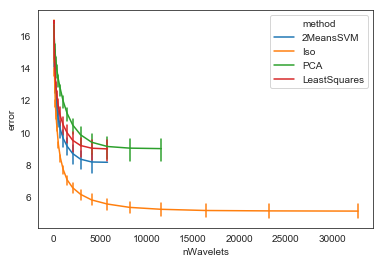

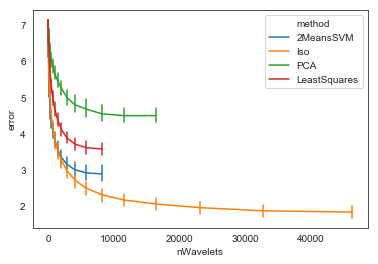

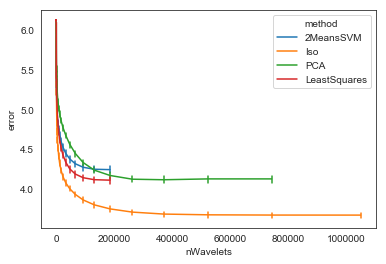

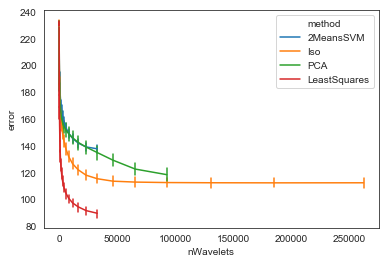

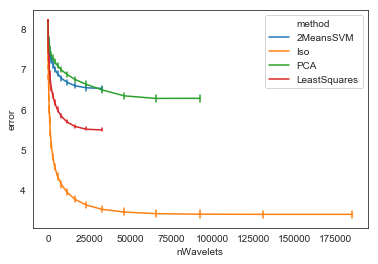

In [83]:
for ds in datasets:
    res = reader.WFResultsReader(ds, methods, "../")
    sns.lineplot(data=res.error_by_nwavelets['Testing'], x='nWavelets', y = 'error',hue='method', err_style='bars')
    plt.show()

In [9]:
class WFSingleResultsReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.Mterm = self.read_mterm()
        self.Mterms = self.read_mterm(plural=True)
        self.mterm_nwavelets = self.read_mterm_nwavelets()
        self.threshold = self.read_threshold()
        self.mterm_error = self.read_mterm_err()
        self.error_by_forest = self.read_error_by_forest()
        self.nwavelets = self.read_nwavelets()
        
        self.alpha_mterm = self.read_alpha_mterm()
        
    @staticmethod
    def inst_path(path):
        return path if type(path) == pl.PosixPath else pl.Path(path)
    
    def read_threshold(self):
        return pd.read_csv(self.pl_path.joinpath("threshold.txt"), names=["t"],dtype={'t':np.float64}, squeeze=True).values[0]
    
    def read_mterm(self, plural = False):
        _s = "Mterms.txt" if plural else "Mterm.txt"
        return pd.read_csv(self.pl_path.joinpath(_s), names=["MT"], squeeze=True).values[0]
    
    def read_mterm_err(self):
        _d = {"Training":None, "Testing":None, "Validating":None}
        for k in _d.keys():
            _d[k] = pd.read_csv(self.pl_path.joinpath("mTermErrorOn{}.txt".format(k)), names=['error'])
            _d[k]['nWavelets']= self.mterm_nwavelets
        return _d
    
    def read_error_by_forest(self):
        _d = {"Train":None, "Test":None, "Valid":None}
        for k in _d.keys():
            _d[k] = pd.DataFrame(columns=['None', self.threshold])
            _d[k]["None"] = pd.read_csv(self.pl_path.joinpath("{}errorByForest.txt".format(k)), names=['None'], squeeze=True)
            thresh_path = list(self.pl_path.glob("{}errorByForestWithThreshold{}*.txt".format(k,str(self.threshold)[:4])))[0]
            _d[k][self.threshold] = pd.read_csv(self.pl_path.joinpath(thresh_path.name), names=[self.threshold], squeeze=True)
        return _d
    
    def read_nwavelets(self):
        _d = pd.DataFrame(columns=['None', self.threshold])
        _d["None"] = pd.read_csv(self.pl_path.joinpath("NwaveletsInRF.txt"), names=['None'], squeeze=True)
#         _d[self.threshold] = pd.read_csv(self.pl_path.joinpath("NwaveletsInRFWithThreshold{}.txt".format(self.threshold)), names=[self.threshold], squeeze=True)
        return _d
    
    def read_mterm_nwavelets(self):
        return pd.read_csv(self.pl_path.joinpath("mTermNwavelets.txt"), names=['mTermNwavelets'], squeeze=True)
    
    def read_alpha_mterm(self):
        return pd.read_csv(self.pl_path.joinpath("alphaMterm.txt"), names=['alphaMterm'], squeeze=True).values[0]
    
class WFDirectoryReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.rf_list = list(map(lambda x:WFSingleResultsReader(x), [d for d in self.pl_path.iterdir() if d.is_dir()]))
        self.nwavelets = self.melt_nwavelets()
        self.error_by_nwavelets = self.melt_mterm_error()
        self.error_by_tree = self.melt_error_by_tree()
        self.alpha_mean = np.array([wf.alpha_mterm for wf in self.rf_list]).mean()
        
    def melt_nwavelets(self):
        def prep_table(wf, i):
            _d = wf.nwavelets.loc[:,["None"]].reset_index().copy()
            _d['#wf'] = i
            return _d
        
        return pd.concat([prep_table(wf,i) for i,wf in enumerate(self.rf_list)])
    
    def melt_mterm_error(self):
        _d = {"Training":None, "Testing":None, "Validating":None}
        def prep_table(table,i):
            __d = table.copy()
            __d['#wf'] = i
            return __d
        
        for k in _d.keys():
            _d[k] = pd.concat([prep_table(wf.mterm_error[k],i) for i,wf in enumerate(self.rf_list)])
        return _d
    
    def melt_error_by_tree(self):
        _d = {"Train":None, "Test":None, "Valid":None}
        def prep_table(_wf, key,i):
            __d = _wf.error_by_forest[key].copy()
            __d = pd.melt(__d, value_name='Error',var_name='Threshold')
            __d['Threshold'] = __d['Threshold'].apply(lambda x: 'No threshold' if x =='None' else 'With threshold')
            __d['#wf'] = i
            return __d
        
        for k in _d.keys():
            _d[k] = pd.concat([prep_table(wf, k,i) for i,wf in enumerate(self.rf_list)])
        return _d
    
class WFResultsReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.wf_dict = {'iso': WFDirectoryReader(self.pl_path.joinpath("Isotropic")), 
                  'aniso':WFDirectoryReader(self.pl_path.joinpath("UnIsotropic"))}
        self.error_by_nwavelets = self.melt_nwavelets()
        self.error_by_tree = self.melt_error_by_tree()
        
    def melt_nwavelets(self):
        _dict = {"Training":None, "Testing":None, "Validating":None}
        for k in _dict.keys():
            _dfl = []
            for m in self.wf_dict.keys():
                _df = self.wf_dict[m].error_by_nwavelets[k].copy()
                _df['method'] = "{}, alpha: {}".format(m, np.round(self.wf_dict[m].alpha_mean, 4))
                _dfl.append(_df.copy())
                
            _dict[k] = pd.concat(_dfl)
        return _dict
    
    def melt_error_by_tree(self):
        _dict = {"Train":None, "Test":None, "Valid":None}
        for k in _dict.keys():
            _dfl = []
            for m in self.wf_dict.keys():
                _df = self.wf_dict[m].error_by_tree[k].copy()
                _df['method'] = "{}, alpha: {}".format(m, np.round(self.wf_dict[m].alpha_mean, 4))
                _dfl.append(_df.copy())
                
            _dict[k] = pd.concat(_dfl)
        return _dict
    
    def plot_error_by_nwavelets(self, size=[20, 6]):
        plt.figure(figsize=size)
        
        for i,k in enumerate(['Training','Testing','Validating']):
            plt.subplot(131+i)
            _a = sns.lineplot(data = self.error_by_nwavelets[k], x='nWavelets', y="error", hue='method', legend='full')
            _a.set_title(k)
            
    def plot_error_by_tree(self, size=[18, 6]):
        plt.figure(figsize=size)
        
        for i,k in enumerate(['Train','Test','Valid']):
            plt.subplot(131+i)
            _a = sns.boxplot(data = self.error_by_tree[k], x='method', y="Error", hue='Threshold')
            _a.set_title(k)
            if i > 0:
                _a.legend_.set_visible(False)
#         plt.tight_layout()

/Users/uriamor/anaconda/envs/WF/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


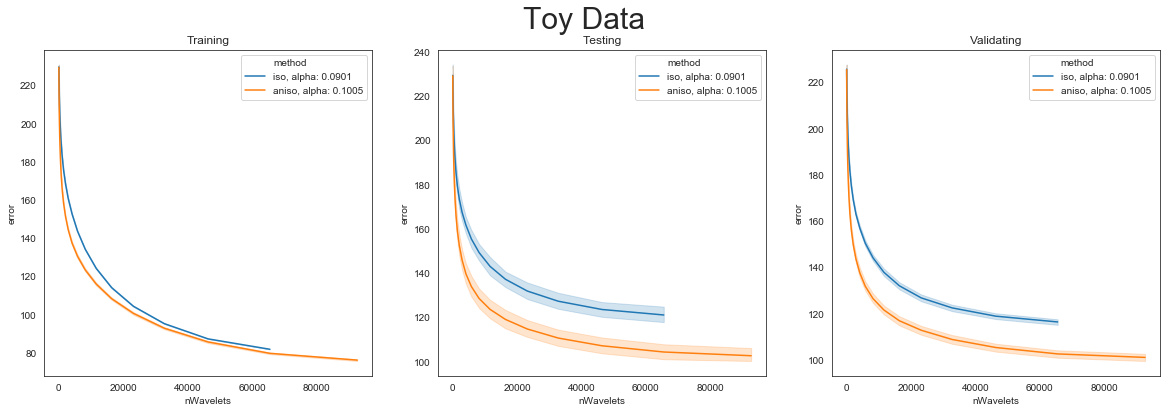

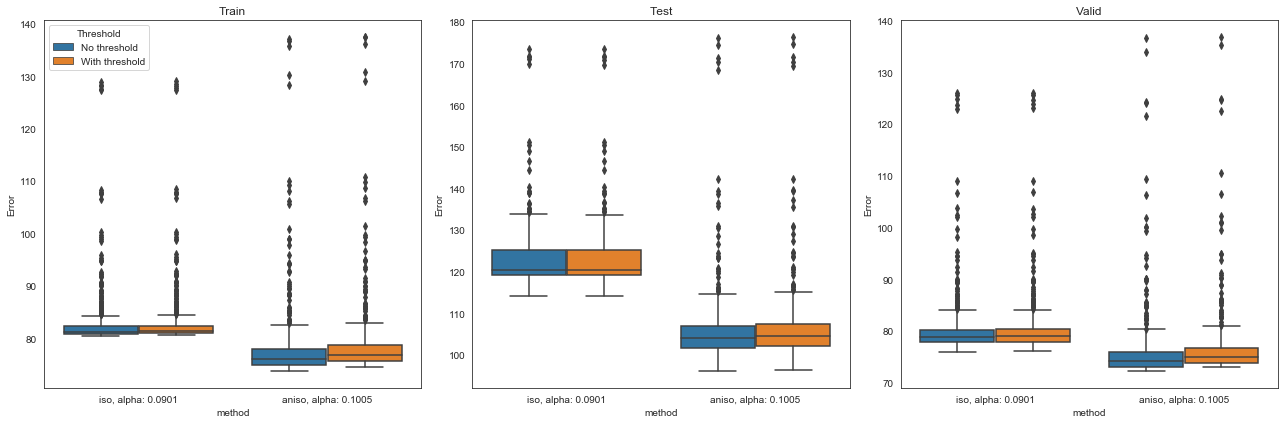

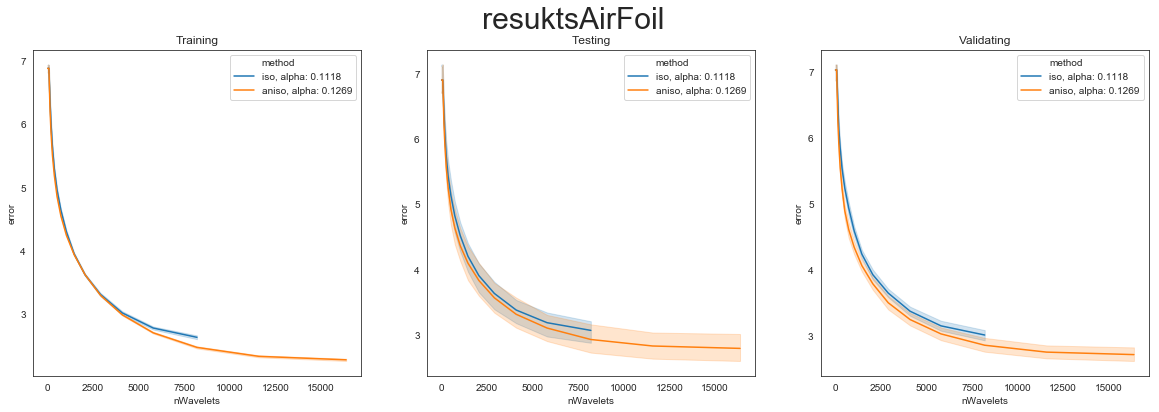

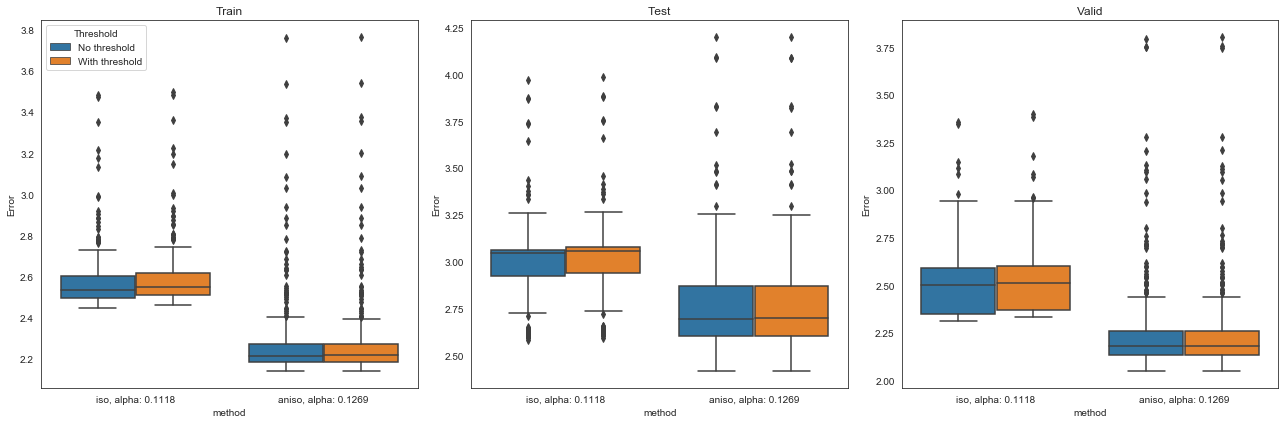

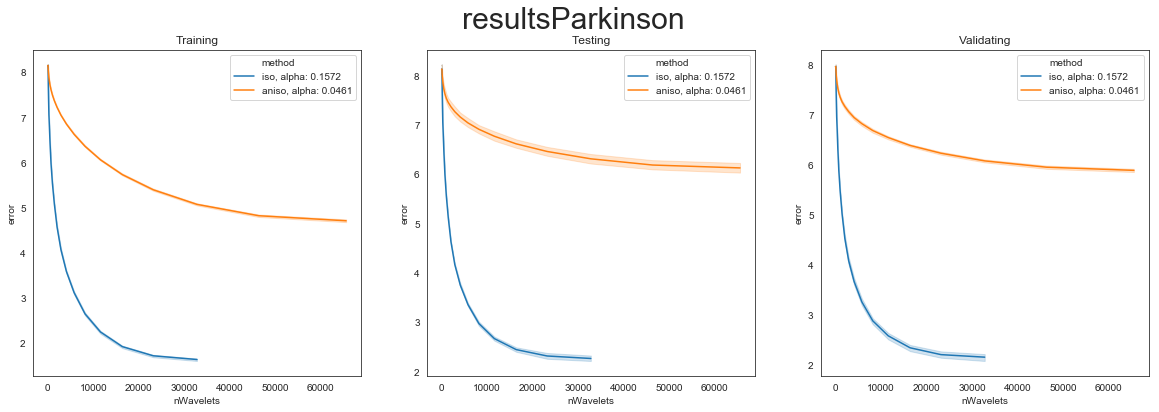

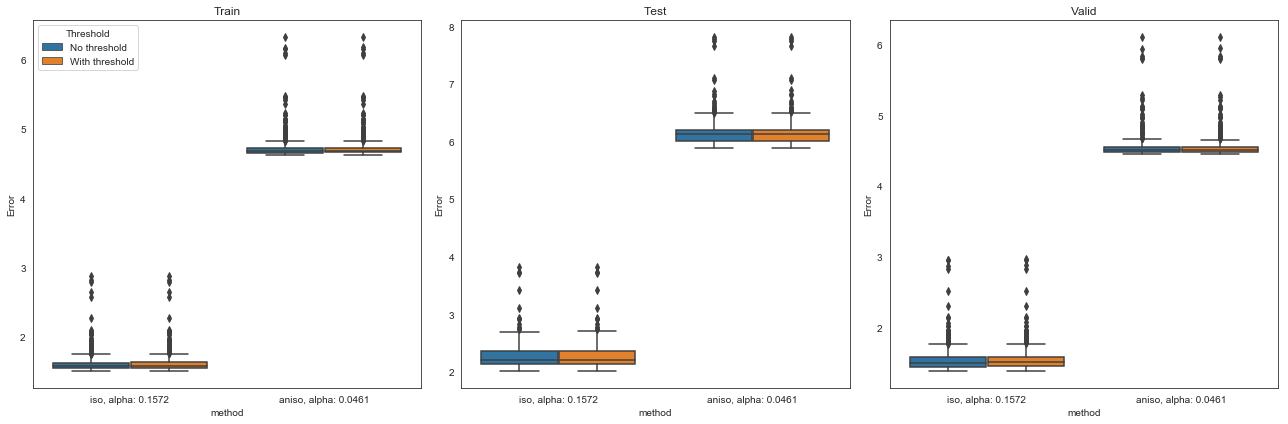

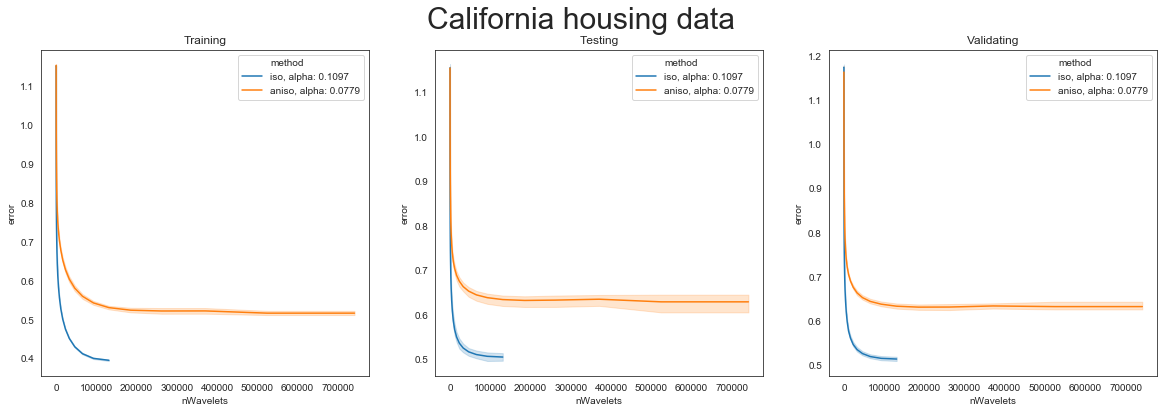

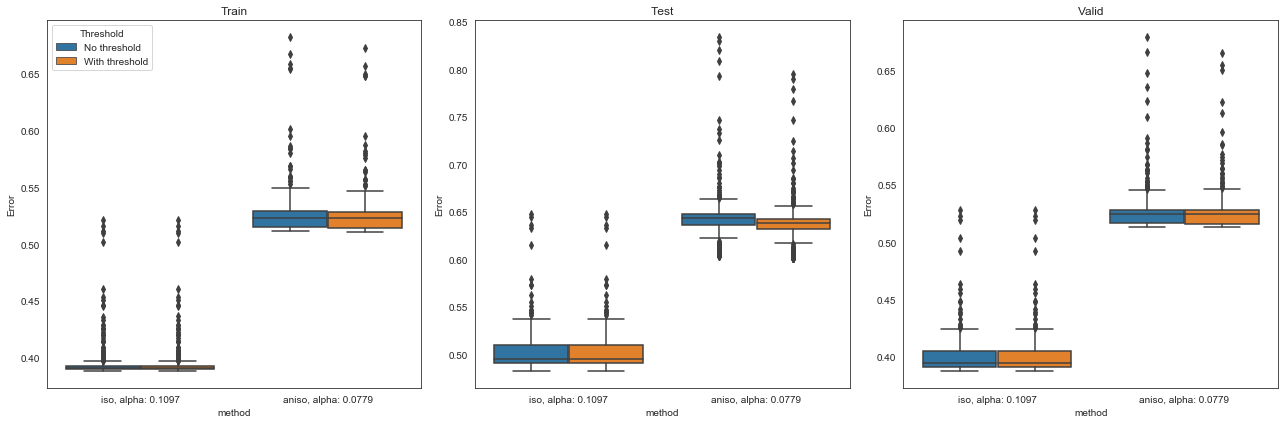

In [10]:
dirs = ["Toy Data",
        "resuktsAirFoil",
        "resultsParkinson",
        "California housing data"]
for d in dirs:
    p = pl.Path("..").joinpath(d)
    
    data = WFResultsReader(p)
    data.plot_error_by_nwavelets()
    plt.suptitle(d, size = 30)
    data.plot_error_by_tree()
    plt.tight_layout()
    plt.show()